In [1]:
import statsmodels.api as sm
import pandas as pd
import re,string
import nltk
from patsy import dmatrices
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import warnings
%pylab inline
import numpy as np
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("edmunds_comments.csv",encoding='iso-8859-1')
df.post = df.post.astype(str)
print(df.dtypes)
df.head()

date        object
username    object
post        object
quotes      object
dtype: object


,date,username,post,quotes
0,b'September 7',b'dino001',b'If they keep it around in next four-five yea...,"b""The lease rate is the factor that stops me c..."
1,b'September 7',b'circlew',b'2018 430i Gran Coupe',"b""show previous quotes\n\n\nThe Stinger is too..."
2,b'September 8',b'qbrozen',"b""The lease rate is the factor that stops me c...",b''
3,b'September 9',b'FlightNurse2',"b""circlew said:\nThe lease rate is the factor ...","b'Again, the local dealer are hopeless at best..."
4,b'September 9',b'roadburner',"b""'17 F150 Crew 2.7; '67 Coronet R/T; '14 Town...","b'Thanks, but I am more than aware of the dist..."


In [3]:
#clean punctuation and white spaces
df["post_clean"] = df.post.apply(lambda x:re.sub(r"[^a-zA-Z0-9\s]", " ", x.lower()))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r"\n", " ", x.lower()))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r'\s+', ' ', x))

In [4]:
#removing stop words
stop = set(stopwords.words('english'))
df['post_clean'] = df.post_clean.apply(lambda x: [word for word in x.split() if word not in stop])

In [5]:
df.head()

,date,username,post,quotes,post_clean
0,b'September 7',b'dino001',b'If they keep it around in next four-five yea...,"b""The lease rate is the factor that stops me c...","[b, keep, around, next, four, five, years, thi..."
1,b'September 7',b'circlew',b'2018 430i Gran Coupe',"b""show previous quotes\n\n\nThe Stinger is too...","[b, 2018, 430i, gran, coupe]"
2,b'September 8',b'qbrozen',"b""The lease rate is the factor that stops me c...",b'',"[b, lease, rate, factor, stops, cold, taking, ..."
3,b'September 9',b'FlightNurse2',"b""circlew said:\nThe lease rate is the factor ...","b'Again, the local dealer are hopeless at best...","[b, circlew, said, nthe, lease, rate, factor, ..."
4,b'September 9',b'roadburner',"b""'17 F150 Crew 2.7; '67 Coronet R/T; '14 Town...","b'Thanks, but I am more than aware of the dist...","[b, 17, f150, crew, 2, 7, 67, coronet, r, 14, ..."


### Replacing model with make in the corpus

In [6]:
#importing model list
car_models = pd.read_csv("car_models_curated.csv")
print(car_models.dtypes)
car_models.head()

make      object
model1    object
dtype: object


,make,model1
0,ACURA,CL
1,ACURA,CSX
2,ACURA,EL
3,ACURA,ILX
4,ACURA,INTEGRA


In [7]:
car_models["model1"]=car_models["model1"].astype(str)
car_models["make"] = car_models["make"].apply(lambda x:re.sub(r"[^\w\s]", "", x.lower()))
car_models["model1"] = car_models["model1"].map(lambda x:re.sub(r"[^\w\s]", "", x.lower()))

In [8]:
#converting into dictionary
#This will help in identifying make for corresponding model
car_dict = car_models.set_index('model1').transpose().to_dict()
model = "beetle"
car_dict[model]['make']

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  This is separate from the ipykernel package so we can avoid doing imports until


'volkswagen'

In [9]:
model1 = set(car_models["model1"])

In [10]:
#replace model with make
df["post_c2"] = df.post_clean.map(lambda x: [car_dict[i]['make'] if i in model1 else i for i in x])

### Checking frequency for all values

In [11]:
#getting frequency distribution
car_posts = df['post_c2'].sum()

In [12]:
all_words = nltk.FreqDist(car_posts)
rslt_all = pd.DataFrame.from_dict(all_words,orient='index').reset_index()
rslt_all.columns = ['word','frequency']

### Most popular brands (all)

In [13]:
rslt_all[rslt_all['word'].isin(car_models["make"])].nlargest(10,'frequency')

,word,frequency
0,mercedesbenz,13078
34,bmw,8273
206,acura,6957
298,audi,5766
253,honda,3198
204,infiniti,3095
302,volkswagen,2736
1129,cadillac,1954
5,ford,1477
205,lexus,1421


### Taking unique values (using set)

In [14]:
df["post_cunique"] = df.post_c2.map(lambda x: sorted(set(x)))

In [15]:
cars_unique = df.post_cunique.map(lambda x:[ "".join(word) for word in x]).sum() 

In [16]:
unique_words = nltk.FreqDist(cars_unique)
rslt_unique = pd.DataFrame.from_dict(unique_words,orient='index').reset_index()
rslt_unique.columns = ['word','frequency']

### Most popular brands (unique)

In [17]:
rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(10,'frequency')

,word,frequency
38,mercedesbenz,12550
7,bmw,3758
193,acura,2517
301,audi,2007
310,volkswagen,1636
264,honda,1591
207,infiniti,1513
19,ford,1023
1128,cadillac,859
208,lexus,800


### Calculate Lift Ratio

Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on the Internet). 

In [18]:
def get_lift(a,b,tokenized_data):
    '''Function to calculate lift scores given any two words from a list of tokenized words'''
    if (a==b):
        return 1
    p_a = len([x for i in tokenized_data for x in i if (x == a)])
    p_b = len([x for i in tokenized_data for x in i if (x == b)])
    p_a_b = len([x for i in tokenized_data for x in i if (x in [a,b])])
    n = len(tokenized_data)
    return "%s" % float((n * p_a_b) /(p_a * p_b))

In [19]:
def plot_mds(lift_score,labels, euclidean = 0):
    dissimilarity = 1/lift_score.astype(np.float64)
    adist = np.array(dissimilarity)
    amax = np.amax(adist)
    adist /= amax
    mds = MDS(n_components=2, random_state=6, metric=False, dissimilarity="precomputed")
    res = mds.fit(adist)
    if euclidean == 1:
        similarities = euclidean_distances(lift_score.astype(np.float64))
        mds = MDS(n_components=2, random_state=6, dissimilarity="precomputed")
        res = mds.fit(similarities)
    
    plt.figure(figsize=(12,8))
    plt.scatter(res.embedding_[:,0],res.embedding_[:, 1])

    #plot the brand name labels
    for label, x, y in zip(labels, res.embedding_[:, 0], res.embedding_[:, 1]):
        plt.annotate(label,xy = (x, y), xytext = (-20, 20),textcoords = 'offset points', ha = 'left', va = 'bottom',
                     bbox = dict(boxstyle = 'round,pad=.2', fc = 'orange', alpha = 0.6),
                     arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.show()

### Insights

In [20]:
# plot MDS top 10
num_brands = 10
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
lift_score = [get_lift(x,y,df.post_cunique) for x in top_brands.word for y in top_brands.word] #if x!=y]
xdf = reshape(lift_score,(num_brands,num_brands))

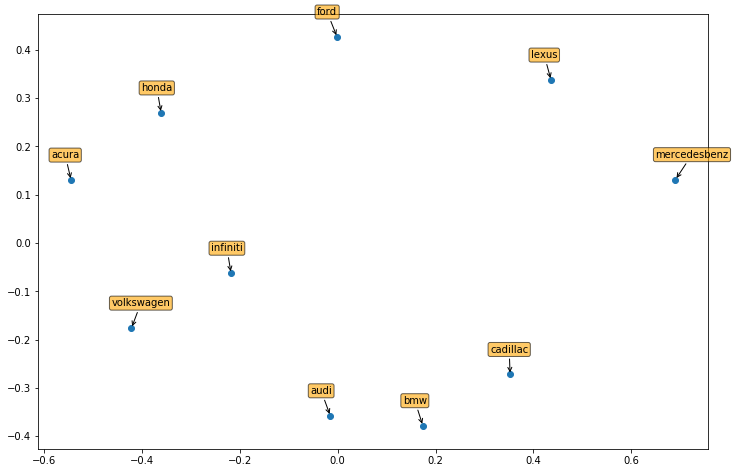

In [21]:
plot_mds(xdf,top_brands.word)

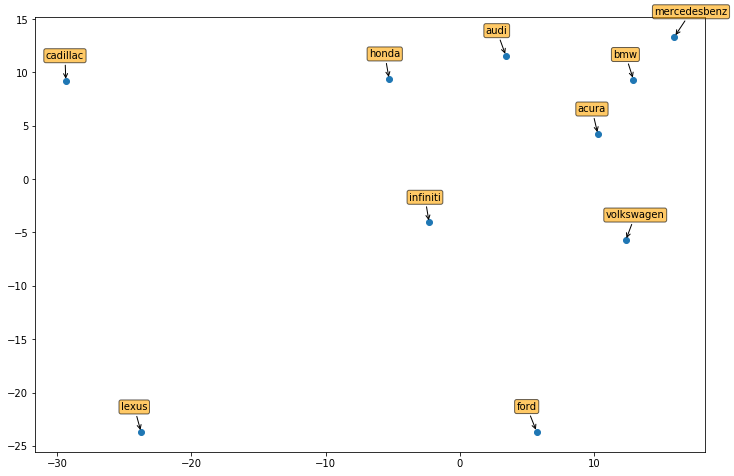

In [22]:
plot_mds(xdf,top_brands.word,1)

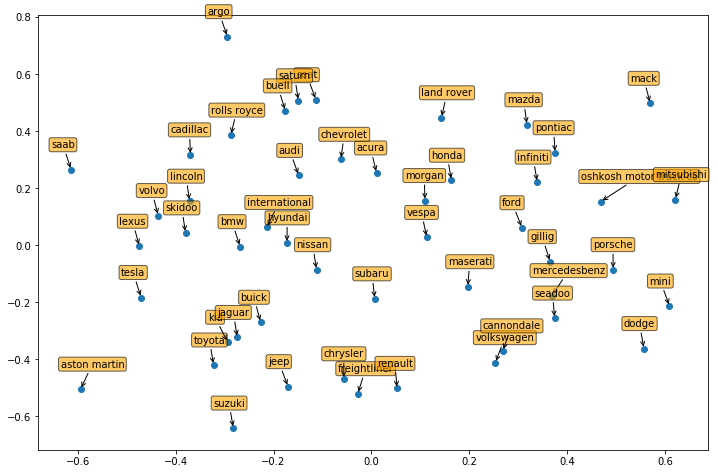

In [23]:
# plot MDS top 50
num_brands = 50
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
lift_score = [get_lift(x,y,df.post_cunique) for x in top_brands.word for y in top_brands.word] #if x!=y]
xdf = reshape(lift_score,(num_brands,num_brands))
plot_mds(xdf,top_brands.word)

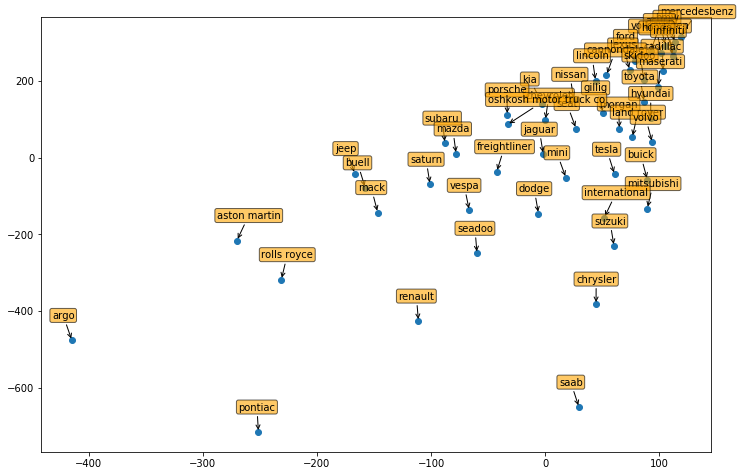

In [24]:
plot_mds(xdf,top_brands.word,1)

### Frequently mentioned attributes for cars

Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? 

In [25]:
#checking most common words in freq_dist
unique_words.most_common(2000)

[('mercedesbenz', 12550),
 ('n', 6239),
 ('car', 3998),
 ('bmw', 3758),
 ('like', 2831),
 ('one', 2614),
 ('acura', 2517),
 ('ni', 2508),
 ('would', 2489),
 ('cars', 2438),
 ('said', 2371),
 ('get', 2237),
 ('audi', 2007),
 ('3', 1951),
 ('think', 1948),
 ('new', 1940),
 ('awd', 1866),
 ('volkswagen', 1636),
 ('even', 1602),
 ('honda', 1591),
 ('good', 1574),
 ('much', 1570),
 ('well', 1519),
 ('infiniti', 1513),
 ('time', 1468),
 ('drive', 1434),
 ('know', 1430),
 ('really', 1374),
 ('better', 1367),
 ('2', 1340),
 ('years', 1285),
 ('also', 1251),
 ('4', 1239),
 ('people', 1227),
 ('price', 1187),
 ('see', 1187),
 ('could', 1173),
 ('still', 1150),
 ('want', 1126),
 ('way', 1125),
 ('5', 1125),
 ('back', 1090),
 ('make', 1083),
 ('nthe', 1080),
 ('sport', 1063),
 ('go', 1045),
 ('say', 1036),
 ('1', 1035),
 ('ford', 1023),
 ('series', 1019),
 ('wife', 994),
 ('driving', 978),
 ('sh', 975),
 ('going', 970),
 ('year', 955),
 ('right', 941),
 ('many', 931),
 ('6', 914),
 ('lot', 909),
 

In [26]:
# creating a dictionary for synonyms of product attributes based on most frequent words
prod_attributes = {'performance':['engine', 'engines', 'power', 'acceleration', 'quality', 'sport', 'mileage', 
                                  'torque', 'suspension', 'speed', 'sports', 'weight', 'suspension','hp'],
                   'transmission':['manual', 'auto', 'automatic', 'automatics', 'transmission','dsg'],
                   'wd':['awd', 'rwd', 'fwd', 'wheel', 'wheels','tires','steering','nif','suspension'],
                   'comfort':['class','interior','leather','brand','premium','seat','seats','experience','comfort','lux','comfortable'],
                   'price':['cheap', 'cheaper', 'costs', 'cost', 'economy', 'value','50k','45k','15k','35k','5k','10k','discount'],
                  }
#tires

In [27]:
def replace_attributes(s):
    for k,v in prod_attributes.items():
        return([k if x==y else y for x in v for y in s])

In [28]:
#replacing product attributes which are synonyms
df["post_attributes"] = df.post_cunique.map(replace_attributes)

In [31]:
num_brands = 10
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
product_list = ['performance','transmission','wd','luxury','price']
lift_score = [get_lift(x,y,df.post_attributes) for x in top_brands.word for y in product_list]

In [37]:
np.around(lift_score,3)

TypeError: ufunc 'multiply' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [36]:
pd.DataFrame(reshape(np.around(lift_score,3),(num_brands,len(product_list))),index =top_brands.word , columns = product_list )

TypeError: ufunc 'multiply' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

### While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on Edmunds? Show your analysis.   

In [ ]:
def conditional_lift(a,b,c,tokenized_data):
    p_ac =
    p_bc =
    p_c =
    p_abc =
    return float((p_abc * p_c)/(p_ac*p_bc))

### Advice to (i) product manager, and (ii) marketing/advertising manager of these brands based on attribute relations

### Most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?